# About

**Task**
Future value estimation based on customer lifetime.

**Requirements**

*Approach 1 – BG-NBD + Gamma–Gamma*
- Fit BG-NBD. Predict:
    - Expected number of future transactions
    - Probability customer is alive
- Fit Gamma–Gamma. Compute:
    - Expected monetary value
    - CLV over time horizon T

*Approach 2 – Survival Analysis + Gamma–Gamma*
- Use survival model output. Predict:
    - Survival curve
    - Expected remaining lifetime
- Fit Gamma–Gamma. Compute:
    - Time-dependent CLV

# Preparation

## Libraries

In [2]:
import pandas as pd

In [3]:
import numpy as np
from scipy import stats

In [4]:
from dotenv import load_dotenv
import os
from pathlib import Path
import joblib

In [5]:
import tempfile
import cloudpickle

In [6]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    add_churn_status
)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from lifetimes import GammaGammaFitter

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [10]:
import mlflow

In [11]:
import traceback

## Environment

In [12]:
load_dotenv()

True

In [13]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [14]:
OBSERVED_DATE = pd.Timestamp('2025-12-31')
OBSERVED_DATE_STR = OBSERVED_DATE.strftime("%d_%m_%Y")

In [15]:
CUTOFF_DATE = OBSERVED_DATE - pd.Timedelta(days=30)

In [16]:
PROJECT_ROOT = Path.cwd().parent

In [17]:
BASE_GOLD_DIR = PROJECT_ROOT / "data" / "gold" / OBSERVED_DATE_STR

In [18]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"
mlflow.set_tracking_uri(f"file://{MLRUNS_DIR}")
EXPERIMENT_NAME = "customer_monetary_modeling"

from mlflow.tracking import MlflowClient
client = MlflowClient()

In [19]:
targets=['is_churn_30_days']

## 02 Notebook Wrappers

I'm temporarily copying the functions from 02 because I haven't put them in the Python package yet.

### Feature Engineering

In [20]:
def get_rfm_window_features(customers_df, transactions_df, observed_date):

    rfm_time_windows = ["all_time", "30d", "60d", "90d"]

    for rfm_time_window in rfm_time_windows:

        if rfm_time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(rfm_time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        # Get a Customers Screenshot Summary DataFrame. It has RFM features and other variables that RFM features depend on.
        summary_modeling_df = get_customers_screenshot_summary_from_transactions_df(
            transactions_df=filtered_transactions_df,
            observed_date=observed_date,
            column_names=["customer_id", "transaction_date", "amount"]
        )

        # Keep only customer_id and the RFM columns we care about
        summary_modeling_df = summary_modeling_df[[
            'customer_id',
            'days_until_observed',
            'period_transaction_count',
            'period_total_amount',
            'period_tenure_days'
        ]]

        # Rename columns in the summary DF, not the main DF
        summary_modeling_df = summary_modeling_df.rename(columns={
            'days_until_observed': f'rfm_recency_{rfm_time_window}',
            'period_transaction_count': f'rfm_frequency_{rfm_time_window}',
            'period_total_amount': f'rfm_monetary_{rfm_time_window}',
            'period_tenure_days': f'tenure_{rfm_time_window}'
        })
        
        # Merge with current data used for modelling.
        customers_df = pd.merge(
            customers_df,
            summary_modeling_df,
            on="customer_id",
            how="left"
        )

    return customers_df

In [21]:
def get_slope_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

    customers_list = filtered_transactions_df['customer_id'].unique()

    slopes = {}

    for customer_id in customers_list:

        customer_transactions = filtered_transactions_df[filtered_transactions_df['customer_id'] == customer_id]

        x = np.arange(len(customer_transactions)) #time axis
        slopes[customer_id] = {} #initiate value list

        for feature_name in feature_list:
            y = customer_transactions[feature_name].values
            x_valid = x[~np.isnan(y)]
            y_valid = y[~np.isnan(y)]

            if len(y_valid) < 2:
                slopes[customer_id][feature_name] = np.nan
            else:
                slope = np.polyfit(x_valid, y_valid, 1)[0]
                slopes[customer_id][feature_name] = slope

    # Convert dict of dicts into dataframe
    slope_features_df = pd.DataFrame.from_dict(slopes, orient='index')

    # Rename columns to have slope_ prefix
    slope_features_df = slope_features_df.rename(columns={f: f'slope_{f}' for f in slope_features_df.columns})

    # Reset index to have customer_id as a column
    slope_features_df = slope_features_df.reset_index().rename(columns={'index': 'customer_id'})

    # Merge with current data used for modelling.
    customers_df = pd.merge(
        customers_df,
        slope_features_df,
        on="customer_id",
        how="left"
    )

    return customers_df

In [22]:
def get_transaction_statistics_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    all_stats_df_list = []

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        customers_list = filtered_transactions_df['customer_id'].unique()
        stats_dict = {}

        for customer_id in customers_list:

            customer_transactions = filtered_transactions_df[
                filtered_transactions_df['customer_id'] == customer_id
            ]

            stats_dict[customer_id] = {}

            for feature_name in feature_list:

                y = customer_transactions[feature_name].dropna().values

                if len(y) < 2:
                    # Less than 2 observations -> return NaN for all stats
                    stats_dict[customer_id][f"min_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mean_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mode_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"max_{feature_name}"] = np.nan
                    for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                        stats_dict[customer_id][f"q{q}_{feature_name}"] = np.nan
                    continue

                # Compute stats
                stats_dict[customer_id][f"min_{feature_name}"] = np.min(y)
                stats_dict[customer_id][f"mean_{feature_name}"] = np.mean(y)

                # Compute mode safely
                mode_result = stats.mode(y, nan_policy='omit')
                if hasattr(mode_result.mode, "__len__"):
                    # old SciPy: mode is array
                    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
                else:
                    # new SciPy: mode is scalar
                    mode_val = mode_result.mode if mode_result.count > 0 else np.nan

                stats_dict[customer_id][f"mode_{feature_name}"] = mode_val

                stats_dict[customer_id][f"max_{feature_name}"] = np.max(y)

                # Quantiles
                for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                    stats_dict[customer_id][f"q{q}_{feature_name}"] = np.percentile(y, q)

        # Convert to dataframe
        stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').reset_index().rename(columns={'index': 'customer_id'})
        all_stats_df_list.append(stats_df)

    # Merge with customers_df (only keep last time_window stats)
    final_stats_df = all_stats_df_list[-1]  # or merge all windows if needed
    customers_df = pd.merge(customers_df, final_stats_df, on='customer_id', how='left')

    return customers_df

In [23]:
def build_training_base(
    seed_customers_path,
    seed_transactions_path,
    train_snapshot_date,
    churn_windows=[30, 60, 90],
):
    """
    Reads raw data, transforms it, limits it to modeling window,
    builds customer modeling table, and adds churn labels.
    """

    # --- Read data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Transform data ---
    transactions_df = transform_transactions_df(transactions_df)
    customers_df = transform_customers_df(customers_df)

    # --- Derive MAX_DATA_DATE internally ---
    max_data_date = transactions_df["transaction_date"].max()

    # --- Limit transactions to snapshot ---
    transactions_modeling_df = transactions_df.loc[
        transactions_df["transaction_date"] <= train_snapshot_date
    ]

    # --- Build customer modeling base ---
    customers_modeling_df = (
        pd.DataFrame({
            "customer_id": transactions_modeling_df["customer_id"].unique()
        })
        .merge(customers_df, on="customer_id", how="inner")
        .drop(columns=["signup_date", "true_lifetime_days", "termination_date"])
    )

    # --- Add churn labels ---
    for nday in churn_windows:
        var_name = f"is_churn_{nday}_days"
        observed_date = max_data_date - pd.Timedelta(days=nday)

        customers_modeling_df = add_churn_status(
            transformed_customers_df=customers_df,
            observed_date=observed_date,
            desired_df=None,
        )
        
        customers_modeling_df = customers_modeling_df.rename(columns={'is_churn': var_name})

    return transactions_modeling_df, customers_modeling_df

### Helpers

In [24]:
def check_nan_in_df_cols(df):
    # Get relative percentage of nulls by column
    null_features_proportion = (
        df.isna().sum() / len(df)
    ).sort_values(ascending=False)

    high_proportion = []
    medium_proportion = []
    low_proportion = []

    for feature, proportion in null_features_proportion.items():
        if proportion >= 0.20:
            high_proportion.append(feature)
        elif 0.05 <= proportion < 0.20:
            medium_proportion.append(feature)
        else:
            low_proportion.append(feature)

    # Build features DataFrame
    features_df = null_features_proportion.reset_index()
    features_df.columns = ["feature", "nan_proportion"]

    features_df["NaN group"] = features_df["feature"].apply(
        lambda f: (
            "High" if f in high_proportion
            else "Medium" if f in medium_proportion
            else "Low"
        )
    )

    # Print counts (same behavior as before)
    print("Total features:", len(df.columns))
    print("Information on NaN values")
    print("====================================")
    print("Number of High Proportion Features:", len(high_proportion))
    print("Number of Medium Proportion Features:", len(medium_proportion))
    print("Number of Low Proportion Features:", len(low_proportion))

    return features_df


In [25]:
def save_X_csv(X_by_target, BASE_GOLD_DIR):

    for target in X_by_target.keys():

        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        X_by_target[target].to_csv(
            target_dir / "X_train.csv",
            index=True,
        )

        print(f"[{target}] written to {target_dir}")
    
    return "All data saved successfully."

In [26]:
def save_y_csv(
        X_by_target,
        y,
        BASE_GOLD_DIR
    ):

    for target in targets:
        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        # ----------------------------
        # TRAIN labels
        # ----------------------------
        y.loc[
            X_by_target[target].index, target
        ].to_csv(
            target_dir / "y_train.csv",
            header=True,
        )
    
    return "All data saved successfully."

In [27]:
def save_raw_features_csv(df, split, base_gold_dir, index_name='customer_id'):
    
    path = Path(base_gold_dir) / "raw"
    path.mkdir(parents=True, exist_ok=True)

    print("WRITING TO:", path.resolve())

    df.index.name = index_name
    df.to_csv(
        path / f"{split}_features.csv",
        index=True, # keep customer_id
    )

In [28]:
def save_transformed_by_target_csv(X_by_target, split, base_gold_dir, index_name='customer_id'):

    for target, df in X_by_target.items():
        
        base_path = Path(base_gold_dir) / "transformed" / target
        base_path.mkdir(parents=True, exist_ok=True)

        df.index.name = index_name
        df.to_csv(
            base_path / f"X_{split}.csv",
            index=True,  # keep customer_id
        )

In [29]:
def load_transformed(BASE_GOLD_DIR, split, target):
    return pd.read_csv(
        BASE_GOLD_DIR / "transformed" / target / f"X_{split}.csv",
        index_col=0,
    )

### Feature Transformation

In [30]:
def mutual_information_feature_selection(
    X_train,
    y_train,
    target,
    cutoff=0.0,
    random_state=42
):
    """
    Perform mutual information–based feature selection for a given target.

    Returns:
        selected_df: DataFrame with selected features
        mi_scores: DataFrame with MI scores per feature
        selected_features: Index of selected feature names
    """

    assert X_train.index.equals(y_train.index)

    mi_train = mutual_info_classif(
        X_train,
        y_train[target],
        random_state=random_state
    )

    mi_scores = (
        pd.DataFrame(
            mi_train,
            index=X_train.columns,
            columns=["mutual_info"]
        )
        .sort_values(by="mutual_info", ascending=False)
    )

    selected_features = mi_scores.loc[
        mi_scores["mutual_info"] > cutoff
    ].index

    selected_df = X_train[selected_features]

    return selected_df, mi_scores, selected_features

### Feature Processing Pipeline

In [31]:
def add_transaction_time_features(transactions_df):
    """
    Add time-based and order-based transaction features.

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Must contain: customer_id, transaction_date

    Returns
    -------
    pd.DataFrame
        Copy of transactions_df with added features
    """

    df = transactions_df.sort_values(
        ["customer_id", "transaction_date"]
    ).copy()

    df["customer_transaction_order"] = (
        df.groupby("customer_id").cumcount()
    )

    df["prev_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(1)
    )

    df["next_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(-1)
    )

    df["days_since_previous_transaction"] = (
        df["transaction_date"] - df["prev_transaction_date"]
    ).dt.days

    df["days_until_next_transaction"] = (
        df["next_transaction_date"] - df["transaction_date"]
    ).dt.days

    df["first_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"]
        .transform("min")
    )

    df["days_since_first_transaction"] = (
        df["transaction_date"] - df["first_transaction_date"]
    ).dt.days

    return df

In [32]:
def build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    Build raw customer-level features from transactions and customers data.
    No imputing, scaling, or selection is performed here.
    """

    # 1. Transaction-level features
    transactions_df = add_transaction_time_features(
        transactions_modeling_df
    )

    # 2. RFM window features
    customers_df = get_rfm_window_features(
        customers_df=customers_modeling_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
    )

    # 3. Activity trend (slopes)
    customers_df = get_slope_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # 4. Transaction statistics
    customers_df = get_transaction_statistics_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    return customers_df

In [33]:
def fit_numeric_transformers(
    X_train_numeric_df,
    imputer_params=None,
    scaler_params=None,
):
    """
    Fit numeric imputer and scaler on training data only.

    Returns
    -------
    X_train_numeric_imputed_scaled_df : pd.DataFrame
    numeric_imputer : fitted IterativeImputer
    scaler : fitted StandardScaler
    """

    # -------------------------------
    # Defaults
    # -------------------------------
    if imputer_params is None:
        imputer_params = dict(
            estimator=LinearRegression(),
            max_iter=20,
            random_state=42,
        )

    if scaler_params is None:
        scaler_params = {}

    # -------------------------------
    # Imputation (FIT)
    # -------------------------------
    numeric_imputer = IterativeImputer(**imputer_params)
    X_train_numeric_imputed = numeric_imputer.fit_transform(X_train_numeric_df)

    X_train_numeric_imputed_df = pd.DataFrame(
        X_train_numeric_imputed,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    # -------------------------------
    # Scaling (FIT)
    # -------------------------------
    scaler = StandardScaler(**scaler_params)
    X_train_numeric_imputed_scaled = scaler.fit_transform(
        X_train_numeric_imputed_df
    )

    X_train_numeric_imputed_scaled_df = pd.DataFrame(
        X_train_numeric_imputed_scaled,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    return (
        numeric_imputer,
        scaler,
    )

In [34]:
def transform_customers_numeric_features(
    X_numeric,
    numeric_imputer,
    scaler,
):
    """
    Apply fitted numeric imputer and scaler.
    """

    X_numeric_imputed = numeric_imputer.transform(X_numeric)
    X_numeric_imputed_df = pd.DataFrame(
        X_numeric_imputed,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    X_numeric_scaled = scaler.transform(X_numeric_imputed_df)
    X_numeric_scaled_df = pd.DataFrame(
        X_numeric_scaled,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    return X_numeric_scaled_df


In [35]:
def select_features_per_target(
    X_train_transformed_df,
    y_train,
    targets,
    artifact_dir=None,
    cutoff=0.0,
    random_state=42,
):
    """
    Perform feature selection per target using mutual information.
    """

    assert X_train_transformed_df.index.equals(y_train.index), (
        "X_train and y_train must be index-aligned"
    )

    X_train_by_target = {}
    selected_features_by_target = {}
    mi_scores_by_target = {}

    for target in targets:
        X_selected_df, mi_scores, selected_features = (
            mutual_information_feature_selection(
                X_train=X_train_transformed_df,
                y_train=y_train,
                target=target,
                cutoff=cutoff,
                random_state=random_state,
            )
        )

        if artifact_dir is not None:
            with open(
                artifact_dir / f"selected_features_{target}.json",
                "w",
            ) as f:
                json.dump(list(selected_features), f)

        X_train_by_target[target] = X_selected_df
        selected_features_by_target[target] = list(selected_features)
        mi_scores_by_target[target] = mi_scores

        print(f"[{target}] selected {len(selected_features)} features")

    return (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    )

In [36]:
def get_features_per_target(
    X_transformed_df,
    selected_features_by_target
):
    """
    Perform feature selection per target using mutual information.
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():

        missing_features = set(selected_features) - set(
            X_transformed_df.columns
        )
        if missing_features:
            raise ValueError(
                f"Missing selected features at inference time: {missing_features}"
            )

        X_selected_features = X_transformed_df[selected_features]
        X_by_target[target] = X_selected_features

    return X_by_target

In [37]:
def split_train_test_val(
    customers_modeling_df,
    targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
):
    """
    Split customer modeling dataframe into train / val / test sets.

    Parameters
    ----------
    customers_modeling_df : pd.DataFrame
        Must contain customer_id and target columns.
    targets : list[str]
        Target column names.
    test_size : float
        Proportion of data used for test+val split.
    val_size : float
        Proportion of test split used for validation.
    random_state : int

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
    """

    # -------------------------------
    # Feature / target separation
    # -------------------------------
    X_df = customers_modeling_df.drop(columns=targets)
    X_df = X_df.set_index("customer_id", drop=True)

    y_df = customers_modeling_df[["customer_id"] + targets]
    y_df = y_df.set_index("customer_id", drop=True)

    # -------------------------------
    # Train / temp split
    # -------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_df,
        y_df,
        test_size=test_size,
        random_state=random_state,
    )

    # -------------------------------
    # Test / validation split
    # -------------------------------
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        random_state=random_state,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [38]:
def build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df,
    X_train,
    y_train,
    observed_date,
    targets,
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TRAIN data.
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_train_raw_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_train,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Numeric transform (impute + scale)
    # --------------------------------------------------
    X_train_raw_features_df = X_train_raw_features_df.set_index("customer_id", drop=False)
    X_train_raw_features_numeric_df = X_train_raw_features_df.select_dtypes(include="number")

    numeric_imputer, scaler = fit_numeric_transformers(
        X_train_raw_features_numeric_df,
        imputer_params=None,
        scaler_params=None,
    )

    X_train_transformed_df = transform_customers_numeric_features(
        X_train_raw_features_numeric_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 3. Feature selection per target (EXTRACTED)
    # --------------------------------------------------
    (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    ) = select_features_per_target(
        X_train_transformed_df=X_train_transformed_df,
        y_train=y_train,
        targets=targets,
        artifact_dir=ARTIFACT_DIR,
    )

    # --------------------------------------------------
    # 4. Save transformers ONCE
    # --------------------------------------------------
    if ARTIFACT_DIR is not None:
        joblib.dump(
            numeric_imputer,
            ARTIFACT_DIR / "numeric_imputer.joblib",
        )
        joblib.dump(
            scaler,
            ARTIFACT_DIR / "scaler.joblib",
        )

    X_train_raw_features_df = X_train_raw_features_df.drop(columns=['customer_id'])

    return (
        X_train_raw_features_df,
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
        numeric_imputer,
        scaler,
    )

In [39]:
def build_and_transform_customer_features_pipeline_test(
    transactions_modeling_df,
    X_test,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TEST / VAL / INFERENCE data.

    Steps
    -----
    1. Build raw customer-level features from transactions
    2. Remove customer_id from feature space
    3. Apply fitted numeric transformations (imputer + scaler)
    4. Select precomputed feature subset (STRICT reuse)
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_test_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_test,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Set customer_id as index and REMOVE from features
    # --------------------------------------------------
    if "customer_id" not in X_test_features_df.columns:
        raise ValueError("customer_id column missing after feature building")

    X_test_features_df = X_test_features_df.set_index("customer_id", drop=True)

    # --------------------------------------------------
    # 3. Select numeric features and enforce column order
    # --------------------------------------------------
    X_test_numeric_features_df = X_test_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    # --------------------------------------------------
    # 4. Apply fitted numeric transformations (NO FIT)
    # --------------------------------------------------
    X_test_numeric_features_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 5. Feature selection (STRICT reuse)
    # --------------------------------------------------
    missing_features = set(selected_features) - set(
        X_test_numeric_features_transformed_df.columns
    )
    if missing_features:
        raise ValueError(
            f"Missing selected features at inference time: {missing_features}"
        )

    X_test_final_df = X_test_numeric_features_transformed_df[selected_features]

    return X_test_final_df

In [40]:
def transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df,
    numeric_imputer,
    scaler,
    selected_features_by_target
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    # Select numeric features and enforce column order
    X_test_numeric_features_df = X_test_raw_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    X_test_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    X_by_target = get_features_per_target(
        X_test_transformed_df,
        selected_features_by_target
    )

    return X_by_target

In [41]:
def build_and_transform_for_multiple_targets(
    transactions_modeling_df,
    X_df,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features_by_target,
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():
        X_by_target[target] = build_and_transform_customer_features_pipeline_test(
            transactions_modeling_df=transactions_modeling_df,
            X_test=X_df,
            observed_date=observed_date,
            numeric_imputer=numeric_imputer,
            scaler=scaler,
            selected_features=selected_features,
            feature_list=[
                "amount",
                "days_since_previous_transaction",
                "days_until_next_transaction",
                "customer_transaction_order",
                "days_since_first_transaction",
            ],
        )

    return X_by_target

### Model

In [42]:
def plot_lgb_feature_importance(
    model,
    importance_type="gain",   # "gain" or "split"
    normalize=False,
    top_n=None,
    title=None,
    height=600,
    as_percent=True
):
    """
    Plot LightGBM feature importance for sklearn API models.
    """

    # --- Extract feature names ---
    if hasattr(model, "feature_name_"):
        features = model.feature_name_
    else:
        raise ValueError("Model does not contain feature names")

    # --- Extract importance correctly ---
    if importance_type == "split":
        importance = model.feature_importances_
    elif importance_type == "gain":
        importance = model.booster_.feature_importance(importance_type="gain")
    else:
        raise ValueError("importance_type must be 'gain' or 'split'")

    df = pd.DataFrame({
        "feature": features,
        "importance": importance
    })

    # Remove zero-importance features
    df = df[df["importance"] > 0]

    # --- Normalize if requested ---
    if normalize:
        total = df["importance"].sum()
        df["importance"] = df["importance"] / total
        if as_percent:
            df["importance"] *= 100
            importance_label = "Normalized Gain (%)"
            text_fmt = ".2f"
        else:
            importance_label = "Normalized Gain"
            text_fmt = ".4f"
    else:
        importance_label = (
            "Gain" if importance_type == "gain" else "Split Count"
        )
        text_fmt = ".2f"

    # Sort and keep top N
    df = df.sort_values("importance", ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Reverse for horizontal bar chart
    df = df.sort_values("importance", ascending=True)

    if title is None:
        norm_tag = " (Normalized)" if normalize else ""
        title = f"LightGBM Feature Importance ({importance_type.capitalize()}){norm_tag}"

    fig = px.bar(
        df,
        x="importance",
        y="feature",
        orientation="h",
        title=title,
        labels={
            "importance": importance_label,
            "feature": "Feature"
        },
        text=df["importance"]
    )

    fig.update_traces(
        texttemplate=f"%{{text:{text_fmt}}}",
        textposition="outside",
        cliponaxis=False
    )

    fig.update_layout(
        height=height,
        yaxis=dict(categoryorder="total ascending"),
        margin=dict(r=120)
    )

    fig.show()

In [43]:
def evaluate_binary_model(model, X, y, threshold=0.5):
    """
    Evaluate a binary classifier.
    """

    y_proba = model.predict(X, num_iteration=model.best_iteration_)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": average_precision_score(y, y_proba),
        "confusion_matrix": confusion_matrix(y, y_pred)
    }

    return metrics

In [44]:
def show_styled_df_confusion_matrix(cm):

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    styled_df = (
        cm_df.style
        .background_gradient(cmap="Blues")
        .format("{:.0f}")
    )
    
    return styled_df

In [45]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """
    Evaluate a binary classifier on train, validation, and test sets.
    Prints:
    - ROC-AUC
    - PR-AUC (Precision–Recall)
    - Accuracy
    - Confusion Matrix
    - Classification Report
    """
    print(f"\n===== {name} =====")

    for split_name, X, y in [
        ("TRAIN", X_train, y_train),
        ("TEST", X_test, y_test),
        ("VALIDATION", X_val, y_val),
    ]:
        # Predicted probabilities and labels
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        # Metrics
        roc_auc = roc_auc_score(y, y_proba)
        pr_auc = average_precision_score(y, y_proba)
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        cm_df = pd.DataFrame(
            cm,
            index=["Actual 0", "Actual 1"],
            columns=["Predicted 0", "Predicted 1"]
        )

        # Print results
        print(f"\n{split_name}")
        print("-" * len(split_name))
        print(f"ROC-AUC:      {roc_auc:.4f}")
        print(f"PR-AUC:       {pr_auc:.4f}")
        print(f"Accuracy:     {acc:.4f}")
        print("\nConfusion Matrix:")
        print(cm_df)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

In [46]:
def train_lgbm(
    X_train,
    y_train,
    X_val,
    y_val,
    target,
    dataset_version,
):
    param_grid = {
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [200, 400],
        "max_depth": [-1, 6],
    }

    model = LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
    )

    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="average_precision",
        cv=3,
        verbose=0,
    )

    grid.fit(X_train, y_train[target])

    best_model = grid.best_estimator_

    # ---------- Validation predictions ----------
    val_proba = best_model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba >= 0.5).astype(int)  # explicit threshold

    # ---------- Metrics ----------
    roc_auc = roc_auc_score(y_val[target], val_proba)
    pr_auc = average_precision_score(y_val[target], val_proba)
    precision = precision_score(y_val[target], val_pred)
    recall = recall_score(y_val[target], val_pred)

    cm = confusion_matrix(y_val[target], val_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["actual_0", "actual_1"],
        columns=["pred_0", "pred_1"],
    )

    # ---------- MLflow ----------
    input_example = X_train.iloc[:5]
    signature = infer_signature(
        X_train,
        best_model.predict_proba(X_train)[:, 1],
    )

    mlflow.log_param("dataset_version", dataset_version)
    mlflow.log_param("target", target)
    mlflow.log_params(grid.best_params_)

    mlflow.log_metric("val_roc_auc", roc_auc)
    mlflow.log_metric("val_pr_auc", pr_auc)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)

    mlflow.log_text(
        cm_df.to_string(),
        artifact_file=f"confusion_matrix/{dataset_version}_{target}.txt",
    )

    mlflow.lightgbm.log_model(
        best_model,
        name=f"{dataset_version}_{target}",
        input_example=input_example,
        signature=signature,
    )

### Inference

In [47]:
def promote_to_production(run_id):
    client.set_tag(run_id, "stage", "production")

In [48]:
def get_production_runs():
    return mlflow.search_runs(
        filter_string="tags.stage = 'production'",
        search_all_experiments=True,
        output_format="pandas",
    )

    return runs

In [49]:
def load_production_models():
    prod_runs = get_production_runs()

    models = {}
    metadata = {}

    for _, row in prod_runs.iterrows():
        target = row["params.target"]
        dataset_version = row["params.dataset_version"]
        run_id = row["run_id"]

        model_uri = f"runs:/{run_id}/{dataset_version}_{target}"
        model = mlflow.lightgbm.load_model(model_uri)

        models[target] = model
        metadata[target] = {
            "dataset_version": dataset_version,
            "run_id": run_id,
        }

    return models, metadata

In [50]:
def load_prod_bg_nbd():
    exp = mlflow.get_experiment_by_name("bg-nbd")
    if exp is None:
        raise ValueError("Experiment 'bg-nbd' not found")

    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.stage = 'production'",
        output_format="pandas",
    )

    if runs.empty:
        raise ValueError("No production BG-NBD run found")

    run = runs.iloc[0]
    run_id = run["run_id"]

    metadata = {
        "run_id": run_id,
        "experiment_id": exp.experiment_id,
        "experiment_name": exp.name,
        "params": run.filter(like="params.").to_dict(),
        "metrics": run.filter(like="metrics.").to_dict(),
        "tags": run.filter(like="tags.").to_dict(),
    }

    with tempfile.TemporaryDirectory() as d:
        path = mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path="bg_nbd_model/bg_nbd.pkl",
            dst_path=d,
        )
        model = cloudpickle.load(open(path, "rb"))

    return model, metadata

In [51]:
def get_customer_features(
    customer_ids,
    target,
    metadata,
    raw_features_df,
    transformed_features_by_target,
):
    if isinstance(customer_ids, str):
        customer_ids = [customer_ids]

    dataset_version = metadata[target]["dataset_version"]

    if dataset_version == "raw":
        X = raw_features_df.loc[customer_ids]
    elif dataset_version == "transformed":
        X = transformed_features_by_target[target].loc[customer_ids]
    else:
        raise ValueError(f"Unknown dataset version: {dataset_version}")

    return X

In [52]:
def predict_churn(
    customer_id: str,
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Select features
    # ------------------
    X = get_customer_features(
        customer_ids=[customer_id],
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict
    # ------------------
    model = models[target]
    churn_prob = float(model.predict_proba(X)[0, 1])

    # ------------------
    # Risk labeling (explicit, adjustable)
    # ------------------
    if churn_prob >= 0.7:
        churn_label = "high_risk"
    elif churn_prob >= 0.4:
        churn_label = "medium_risk"
    else:
        churn_label = "low_risk"

    return {
        "churn_probability": round(churn_prob, 4),
        "churn_label": churn_label,
    }

In [53]:
def predict_churns(
    customer_ids: list[str],
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Feature extraction (BULK)
    # ------------------
    X = get_customer_features(
        customer_ids=customer_ids,
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict (BULK)
    # ------------------
    model = models[target]
    churn_probs = model.predict_proba(X)[:, 1]

    # ------------------
    # Risk labeling (vectorized)
    # ------------------
    churn_labels = np.where(
        churn_probs >= 0.7,
        "high_risk",
        np.where(
            churn_probs >= 0.4,
            "medium_risk",
            "low_risk",
        ),
    )

    # ------------------
    # Output (aligned, explicit)
    # ------------------
    return (
        pd.DataFrame(
            {
                "customer_id": customer_ids,
                "churn_probability": churn_probs.round(4),
                "churn_label": churn_labels,
            }
        )
        .set_index("customer_id")
    )

In [54]:
def load_features(
        dataset_version,
        gold_data_version,
        gold_dir="default",
        targets=targets
    ):
    '''
        The service preloads the feature dataframes for faster search.
    '''
    if gold_dir == "default":
        PROJECT_ROOT = Path.cwd().parent
        gold_dir = PROJECT_ROOT / "data" / "gold" / gold_data_version
    
    if dataset_version == "raw":
        feature_df = pd.read_csv(gold_dir / dataset_version / "all_features.csv", index_col=0)
        return feature_df
    elif dataset_version == "transformed":
        X_by_target = {}
        for target in targets:
            feature_df = pd.read_csv(gold_dir / dataset_version / target / "X_all.csv", index_col=0)
            X_by_target[target] = feature_df
        return X_by_target
    else:
        return "Invalid dataset version. Please use only `raw` and `transformed`."

## 03 Notebook Wrappers

### Feature Engineering

In [55]:
def build_cut_30d_features(
    transactions_df: pd.DataFrame,
    customers_df: pd.DataFrame,
    n_days: int,
    observed_date
):
    """
    Builds 30-day cutoff features for BG-NBD modeling.

    Returns:
    - features_df: customer-level modeling table
    - transactions_cut_df: truncated transactions
    """

    cutoff_date = observed_date - pd.Timedelta(n_days, unit='d')

    (
        transactions_cut_df,
        customer_ids_cut_df
    ) = cut_off_customers_and_transactions_df(
        transactions_df=transactions_df,
        customers_df=customers_df,
        n_days=n_days,
        end_date=observed_date
    )

    summary_cut_df = get_lifetimes_summary_df(
        transactions_df=transactions_cut_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date"]
    )

    summary_cut_df = add_churn_status(
        transformed_customers_df=customer_ids_cut_df,
        observed_date=cutoff_date,
        desired_df=summary_cut_df,
    )

    summary_cut_df = summary_cut_df.drop(columns=["termination_date"])

    customer_ids_cut_df = customer_ids_cut_df.set_index("customer_id")

    customer_ids_cut_df["n_purchase_30d"] = get_truth_number_of_purchases(
        transactions_df,
        customer_ids_cut_df.reset_index(),
        n_days,
        observed_date
    )

    customer_ids_cut_df = customer_ids_cut_df.reset_index()

    features_df = pd.merge(
        customer_ids_cut_df,
        summary_cut_df,
        on="customer_id",
        how="inner"
    )

    return features_df

In [56]:
def get_lifetimes_summary_df(
    transactions_df: pd.DataFrame,
    observed_date: pd.Timestamp,
    column_names: list
) -> pd.DataFrame:
    """
    Build a per-customer snapshot summary from a transactions DataFrame.

    The function filters transactions up to the observed date and computes,
    per customer:
        - first transaction date in the period
        - last transaction date in the period
        - number of transactions in the period

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Input transactions data.
    observed_date : pd.Timestamp
        Cutoff date for the snapshot.
    column_names : list
        Column names in the following order:
        [customer_id, transaction_date]

    Returns
    -------
    pd.DataFrame
        Customer-level snapshot summary.
    """

    customer_col, transaction_date_col = column_names

    filtered_df = transactions_df[
        transactions_df[transaction_date_col] <= observed_date
    ]

    summary_df = (
        filtered_df
        .groupby(customer_col, as_index=False)
        .agg(
            period_first_transaction_date=(transaction_date_col, 'min'),
            period_last_transaction_date=(transaction_date_col, 'max'),
            frequency=(customer_col, 'size')
        )
    )

    summary_df['frequency'] = summary_df['frequency'] - 1


    summary_df['T'] = (
        observed_date - summary_df['period_first_transaction_date']
    ).dt.days

    summary_df['recency'] = (
        summary_df['period_last_transaction_date']
        -
        summary_df['period_first_transaction_date']
    ).dt.days

    return summary_df[[customer_col, 'frequency', 'T', 'recency']]

In [57]:
def get_lifetimes_summary_arrays(summary_df):

    n = summary_df.shape[0]
    x = summary_df["frequency"].to_numpy()
    t_x = summary_df["recency"].to_numpy()
    T = summary_df["T"].to_numpy()

    return (n, x, t_x, T)

In [58]:
def cut_off_customers_and_transactions_df(
    transactions_df,
    customers_df,
    n_days=30,
    end_date=pd.Timestamp | None
):
    if end_date==None:
        end_date = transactions_df['transaction_date'].max()
    
    cutoff_date = end_date - pd.Timedelta(days=n_days)
    
    transactions_cut_df = transactions_df[
        (transactions_df["transaction_date"] <= cutoff_date)
    ]

    customer_ids_cut = customers_df[
        customers_df['customer_id'].isin(transactions_cut_df['customer_id'])
    ].reset_index(drop=True)
    
    return transactions_cut_df, customer_ids_cut

In [59]:
def get_bgf_clv_features_df(
    transactions_path: str,
    customers_path: str,
    observed_date,
    cutoff_days: int,
) -> tuple[pd.DataFrame, pd.DataFrame | None, pd.DataFrame, pd.Index]:
    """
    Load raw data, apply transformations, cut data by inactivity window,
    build BG-NBD + RFM features, and optionally compute future CLV ground truth.

    If cutoff_days == 0, future CLV ground truth is skipped.
    """

    # ======================
    # Load & transform raw data
    # ======================
    transactions_df = pd.read_csv(transactions_path)
    transactions_df = transform_transactions_df(transactions_df)

    customers_df = pd.read_csv(customers_path)
    customers_df = transform_customers_df(customers_df)

    # ======================
    # Define cutoff date
    # ======================
    cutoff_date = observed_date - pd.Timedelta(days=cutoff_days)

    # ======================
    # Cut customers & transactions
    # ======================
    transactions_cut_df, customer_ids_cut = cut_off_customers_and_transactions_df(
        transactions_df=transactions_df,
        customers_df=customers_df,
        n_days=cutoff_days,
        end_date=observed_date,
    )

    # ======================
    # Lifetimes (BG-NBD) summary
    # ======================
    summary_cut_df = get_lifetimes_summary_df(
        transactions_df=transactions_cut_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date"],
    )

    # ======================
    # RFM features
    # ======================
    rfm_cut_df = get_customers_screenshot_summary_from_transactions_df(
        transactions_df=transactions_cut_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date", "amount"],
    )

    summary_rfm_features_cut_df = summary_cut_df.merge(
        rfm_cut_df,
        on="customer_id",
        how="inner",
    )

    # ======================
    # Optional: Future CLV ground truth
    # ======================
    if cutoff_days > 0:
        transactions_future_df = transactions_df.loc[
            (transactions_df["transaction_date"] > cutoff_date) &
            (transactions_df["transaction_date"] <= observed_date)
        ]

        truth_clv_df = (
            transactions_future_df
            .groupby("customer_id", as_index=False)
            .agg(CLV_30d=("amount", "sum"))
        )

    else:
        truth_clv_df = None

    clv_features_cut_df = summary_rfm_features_cut_df.copy()

    return (
        clv_features_cut_df,
        truth_clv_df,
        transactions_cut_df,
        customer_ids_cut,
    )

### Evaluate

In [60]:
def evaluate_churn_predictions(
    feature_df: pd.DataFrame,
    target_df: pd.DataFrame | None = None,
    threshold: float = 0.5,
    target_col: str = "is_churn",
    proba_col: str = "p_churn",
):
    """
    feature_df: must contain [proba_col]
    target_df:
        - if provided: must contain [target_col]
        - if None: target_col must already be in feature_df

    Assumes customer_id is the index in both DataFrames.
    """

    # Decide where labels come from
    if target_df is None:
        missing = {target_col, proba_col} - set(feature_df.columns)
        if missing:
            raise ValueError(
                f"feature_df is missing required columns: {missing}"
            )
        eval_df = feature_df.copy()

    else:
        missing_f = {proba_col} - set(feature_df.columns)
        missing_t = {target_col} - set(target_df.columns)

        if missing_f or missing_t:
            raise ValueError(
                f"Missing columns — "
                f"feature_df: {missing_f}, target_df: {missing_t}"
            )

        # Index-based alignment
        eval_df = feature_df.join(
            target_df[[target_col]],
            how="inner"
        )

    # Binary predictions
    eval_df["pred_churn"] = (eval_df[proba_col] >= threshold).astype(int)

    # Metrics
    metrics = {
        "roc_auc": roc_auc_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "pr_auc": average_precision_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "precision": precision_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
        "recall": recall_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
    }

    # Confusion matrix
    cm = confusion_matrix(
        eval_df[target_col],
        eval_df["pred_churn"],
        labels=[0, 1]
    )

    cm_df = pd.DataFrame(
        cm,
        index=["actual_no_churn", "actual_churn"],
        columns=["pred_no_churn", "pred_churn"]
    )

    return metrics, cm_df, eval_df

In [61]:
def get_truth_number_of_purchases(
    transactions_df: pd.DataFrame,
    customer_cut_ids: pd.DataFrame,
    n_days: int,
    end_date=pd.Timestamp | None
):
    """
    Returns the number of purchases per customer in the last `n_days`
    ending at the max transaction_date.
    """

    if end_date==None:
        end_date = transactions_df['transaction_date'].max()
    
    cutoff_date = end_date - pd.Timedelta(days=n_days)
    
    # Filter transactions to relevant customers
    sel_transactions_df = transactions_df[
        transactions_df["customer_id"].isin(customer_cut_ids["customer_id"])
    ]

    # Keep only transactions in the future window
    sel_transactions_df = sel_transactions_df[
        sel_transactions_df["transaction_date"] > cutoff_date
    ]

    # Count purchases per customer
    purchase_counts = (
        sel_transactions_df
        .groupby("customer_id")
        .size()
        .reindex(customer_cut_ids["customer_id"], fill_value=0)
    )

    return purchase_counts

### Train

In [62]:
def log_bg_nbd_model(bgf):
    with tempfile.TemporaryDirectory() as tmpdir:
        path = Path(tmpdir) / "bg_nbd.pkl"
        with open(path, "wb") as f:
            cloudpickle.dump(bgf, f)

        mlflow.log_artifact(path, artifact_path="bg_nbd_model")

In [63]:
def train_bg_nbd(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target_2: str = "n_purchase_30d",
    horizon_days=30,
    threshold: float = 0.5,
):
    """
    Trains a BG-NBD model and evaluates churn when labels are available.

    Assumptions:
    - X_* index = customer_id
    - X_* contain ['frequency', 'recency', 'T']
    - y_* contain ['is_churn'] and share index with X_*
    """

    pred_2 = f'pred_{target_2}'

    # ======================
    # Train BG-NBD
    # ======================
    bgf = BetaGeoFitter()
    bgf.fit(
        frequency=X_train["frequency"],
        recency=X_train["recency"],
        T=X_train["T"],
    )

    # ======================
    # Add predictions (IN PLACE)
    # ======================
    X_train = predict_p_alive_churn_bg_nbd(X_train, bgf)
    X_train = predict_n_purchase_bg_nbd(X_train, bgf, t=horizon_days)

    if X_val is not None:
        X_val = predict_p_alive_churn_bg_nbd(X_val, bgf)
        X_val = predict_n_purchase_bg_nbd(X_val, bgf, t=horizon_days)

    if X_test is not None:
        X_test = predict_p_alive_churn_bg_nbd(X_test, bgf)
        X_test = predict_n_purchase_bg_nbd(X_test, bgf, t=horizon_days)

    # ======================
    # Evaluation helper (inline, no copies)
    # ======================
    def evaluate(X, y, split_name):
        eval_df = X.join(y, how="inner")

        eval_df.loc[:, "pred_churn"] = (
            eval_df["p_churn"] >= threshold
        ).astype(int)

        mae = (
            eval_df[target_2] - eval_df[pred_2]
        ).abs().mean()

        metrics = {
            "roc_auc": roc_auc_score(
                eval_df["is_churn"], eval_df["p_churn"]
            ),
            "pr_auc": average_precision_score(
                eval_df["is_churn"], eval_df["p_churn"]
            ),
            "precision": precision_score(
                eval_df["is_churn"], eval_df["pred_churn"]
            ),
            "recall": recall_score(
                eval_df["is_churn"], eval_df["pred_churn"]
            ),
            "mae": mae,
        }

        cm = confusion_matrix(
            eval_df["is_churn"],
            eval_df["pred_churn"],
        )

        cm_df = pd.DataFrame(
            cm,
            index=["actual_no_churn", "actual_churn"],
            columns=["pred_no_churn", "pred_churn"],
        )

        # MLflow logging
        for k, v in metrics.items():
            mlflow.log_metric(f"{split_name}_{k}", v)

        mlflow.log_text(
            cm_df.to_string(),
            artifact_file=f"confusion_matrix/{split_name}_churn.txt",
        )

        return metrics, cm_df

    results = {
        "model": bgf,
        "train": X_train,
    }

    # ======================
    # Validation evaluation
    # ======================
    if X_val is not None and y_val is not None:
        results["val"] = evaluate(X_val, y_val, "val")

    # ======================
    # Test evaluation
    # ======================
    if X_test is not None and y_test is not None:
        results["test"] = evaluate(X_test, y_test, "test")

    # ======================
    # MLflow model logging (correct for BG-NBD)
    # ======================
    mlflow.log_param("model_type", "BG-NBD")
    mlflow.log_param("target_1", "p_churn")
    mlflow.log_param("target_2", target_2)
    mlflow.log_param("threshold", threshold)

    mlflow.log_param("model_type", "BG-NBD")
    log_bg_nbd_model(bgf)

    return results

### Inference

In [64]:
def predict_n_purchase_bg_nbd(
    X,
    bgf,
    t=30
):
    X["n_purchase"] = bgf.conditional_expected_number_of_purchases_up_to_time(
        t=t,
        frequency=X["frequency"],
        recency=X["recency"],
        T=X["T"]
    )

    X = X.rename(columns={'n_purchase': f'pred_n_purchase_{t}d'})

    return X

In [65]:
def predict_p_alive_churn_bg_nbd(
    X,
    bgf
):
    X["p_alive"] = bgf.conditional_probability_alive(
        X["frequency"],
        X["recency"],
        X["T"]
    )

    X["p_churn"] = 1 - X["p_alive"]

    return X

In [66]:
def predict_user_bg_nbd(
    customer_id: str,
    horizon_days: int,
    summary_df: pd.DataFrame,
    model,
) -> dict:
    X = summary_df.loc[
        summary_df["customer_id"] == customer_id
    ]

    p_alive = (
        predict_p_alive_churn_bg_nbd(X, model)["p_alive"]
        .iloc[0]
        .round(4)
    )

    n_purchase = (
        predict_n_purchase_bg_nbd(X, model, t=horizon_days)
        [f"pred_n_purchase_{horizon_days}d"]
        .iloc[0]
    )

    return {
        "customer_id": customer_id,
        "p_alive": p_alive,
        f"pred_n_purchase_{horizon_days}d": n_purchase,
    }

In [67]:
def predict_users_bg_nbd(
    customer_ids: list[str],
    horizon_days: int,
    summary_df: pd.DataFrame,
    model,
) -> pd.DataFrame:

    X = summary_df.loc[
        summary_df["customer_id"].isin(customer_ids)
    ]

    p_alive = predict_p_alive_churn_bg_nbd(X, model)['p_alive']
    n_purchase = predict_n_purchase_bg_nbd(X, model, t=horizon_days)[f"pred_n_purchase_{horizon_days}d"]

    return pd.DataFrame(
        {
            "p_alive": p_alive.round(4),
            f"pred_n_purchase_{horizon_days}d": n_purchase,
        },
        index=X.index,
    )

## 04 Notebook Wrappers

### Feature Engineering

In [68]:
def add_duration_event(
    customers_df: pd.DataFrame,
    obs_end_date: pd.Timestamp,
    start_col: str = "signup_date",
    termination_col: str = "termination_date",
) -> pd.DataFrame:
    df = customers_df.copy()

    # Ensure datetime
    df[start_col] = pd.to_datetime(df[start_col])
    df[termination_col] = pd.to_datetime(df[termination_col])

    # Event indicator: churn happened by obs_end_date
    df["E"] = (
        df[termination_col].notna()
        & (df[termination_col] <= obs_end_date)
    ).astype(int)

    # End date for duration calculation
    df["end_date"] = df[termination_col].where(
        df["E"] == 1,
        obs_end_date,
    )

    # Duration (in days)
    df["T"] = (df["end_date"] - df[start_col]).dt.days

    # Safety checks
    if (df["T"] < 0).any():
        raise ValueError("Negative durations found — check date logic")

    return df.drop(columns=["end_date"])

In [69]:
def survival_to_churn_proba(
    model,
    X: pd.DataFrame,
    horizon_days: int,
) -> pd.Series:
    """
    Returns P(churn within horizon_days)
    """

    surv_fn = model.predict_survival_function(X)

    probs = []
    for i in range(surv_fn.shape[1]):
        s = surv_fn.iloc[:, i]
        s_h = (
            s.loc[s.index <= horizon_days].iloc[-1]
            if (s.index <= horizon_days).any()
            else s.iloc[0]
        )
        probs.append(1 - s_h)

    return pd.Series(probs, index=X.index, name="p_churn")

In [70]:
def build_survival_dataset(
    seed_customers_path: str,
    seed_transactions_path: str,
    cutoff_date,
    max_data_date,
    churn_windows=[30],
):
    """
    Build survival analysis dataset from customer & transaction CSV paths.

    Returns
    -------
    survival_df : pd.DataFrame
        Feature matrix indexed by customer_id, including duration & event columns
    label_df : pd.DataFrame
        Churn labels indexed by customer_id
    """

    # --- Load raw data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Build modeling base ---
    transactions_modeling_df, customers_modeling_df = build_training_base(
        seed_customers_path=seed_customers_path,
        seed_transactions_path=seed_transactions_path,
        train_snapshot_date=cutoff_date,
        churn_windows=list(churn_windows),
    )

    # --- Feature engineering ---
    raw_features_df = build_customer_features(
        transactions_modeling_df,
        customers_modeling_df,
        observed_date=cutoff_date,
    )

    # --- Add survival targets (T, E) ---
    survival_df = add_duration_event(
        customers_df=raw_features_df,
        obs_end_date=max_data_date,
        start_col="signup_date",
        termination_col="termination_date",
    )

    # --- Extract labels ---
    label_cols = [f"is_churn_{w}_days" for w in churn_windows]
    label_df = survival_df[["customer_id", *label_cols]].set_index("customer_id")

    # --- Drop target / leakage columns ---
    survival_df = survival_df.drop(
        columns=[
            "signup_date",
            "termination_date",
            "true_lifetime_days",
            *label_cols,
        ]
    ).set_index("customer_id")

    return survival_df, label_df

In [71]:
class SurvivalFeaturePipeline(BaseEstimator, TransformerMixin):
    """
    Feature transformation pipeline for survival analysis.

    Steps:
    1. Select feature columns (exclude T, E)
    2. Median imputation
    3. Drop features highly correlated with T
    4. Drop near-zero variance features
    5. Standard scaling
    """

    def __init__(
        self,
        corr_threshold: float = 0.95,
        std_threshold: float = 1e-6,
    ):
        self.corr_threshold = corr_threshold
        self.std_threshold = std_threshold

        self.imputer = SimpleImputer(strategy="median")
        self.scaler = StandardScaler()

        # learned attributes
        self.feature_cols_ = None
        self.keep_cols_ = None

    def fit(self, raw_survival_df: pd.DataFrame, y=None):
        df = raw_survival_df.copy()

        # --- identify feature columns ---
        self.feature_cols_ = [
            c for c in df.columns if c not in {"customer_id", "T", "E"}
        ]

        # --- imputation (fit only) ---
        X = self.imputer.fit_transform(df[self.feature_cols_])
        X = pd.DataFrame(X, columns=self.feature_cols_, index=df.index)

        # --- correlation with T ---
        corr_with_T = X.corrwith(df["T"]).abs()
        keep = corr_with_T[corr_with_T < self.corr_threshold].index

        # --- variance filter ---
        std = X[keep].std()
        self.keep_cols_ = std[std > self.std_threshold].index.tolist()

        # --- fit scaler ---
        self.scaler.fit(X[self.keep_cols_])

        return self

    def transform(self, raw_survival_df: pd.DataFrame):
        df = raw_survival_df.copy()

        X = pd.DataFrame(
            self.imputer.transform(df[self.feature_cols_]),
            columns=self.feature_cols_,
            index=df.index,
        )

        X = self.scaler.transform(X[self.keep_cols_])
        X = pd.DataFrame(X, columns=self.keep_cols_, index=df.index)

        return pd.concat(
            [X, df[["T", "E"]]],
            axis=1,
        )

### Evaluation

In [72]:
def evaluate_churn_predictions(
    feature_df: pd.DataFrame,
    target_df: pd.DataFrame | None = None,
    threshold: float = 0.5,
    target_col: str = "is_churn",
    proba_col: str = "p_churn",
):
    """
    feature_df: must contain [proba_col]
    target_df:
        - if provided: must contain [target_col]
        - if None: target_col must already be in feature_df

    Assumes customer_id is the index in both DataFrames.
    """

    # Decide where labels come from
    if target_df is None:
        missing = {target_col, proba_col} - set(feature_df.columns)
        if missing:
            raise ValueError(
                f"feature_df is missing required columns: {missing}"
            )
        eval_df = feature_df.copy()

    else:
        missing_f = {proba_col} - set(feature_df.columns)
        missing_t = {target_col} - set(target_df.columns)

        if missing_f or missing_t:
            raise ValueError(
                f"Missing columns — "
                f"feature_df: {missing_f}, target_df: {missing_t}"
            )

        # Index-based alignment
        eval_df = feature_df.join(
            target_df[[target_col]],
            how="inner"
        )

    # Binary predictions
    eval_df["pred_churn"] = (eval_df[proba_col] >= threshold).astype(int)

    # Metrics
    metrics = {
        "roc_auc": roc_auc_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "pr_auc": average_precision_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "precision": precision_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
        "recall": recall_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
    }

    # Confusion matrix
    cm = confusion_matrix(
        eval_df[target_col],
        eval_df["pred_churn"],
        labels=[0, 1]
    )

    cm_df = pd.DataFrame(
        cm,
        index=["actual_no_churn", "actual_churn"],
        columns=["pred_no_churn", "pred_churn"]
    )

    return metrics, cm_df, eval_df

### Inference

In [73]:
def train_cox(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "is_churn_30_days",
    horizon_days: int = 30,
    threshold: float = 0.5,
    model_params: dict | None = None,
):
    """
    Trains a Cox model and evaluates churn when labels are available.
    """

    model_params = model_params or {}
    mlflow.log_param("model_type", "cox")

    try:
        # ======================
        # Train Cox
        # ======================
        cph = CoxPHFitter(**model_params)
        cph.fit(
            X_train,
            duration_col="T",
            event_col="E",
        )

        proba_col = f"p_churn_{horizon_days}_days"

        # ======================
        # Add predictions (IN PLACE)
        # ======================
        X_train[proba_col] = survival_to_churn_proba(
            model=cph,
            X=X_train,
            horizon_days=horizon_days,
        )

        if X_val is not None:
            X_val[proba_col] = survival_to_churn_proba(
                model=cph,
                X=X_val,
                horizon_days=horizon_days,
            )

        if X_test is not None:
            X_test[proba_col] = survival_to_churn_proba(
                model=cph,
                X=X_test,
                horizon_days=horizon_days,
            )

        # ======================
        # Evaluation helper
        # ======================
        def evaluate(X, y, split_name):
            if X is None or y is None:
                return None

            metrics, cm_df, eval_df = evaluate_churn_predictions(
                feature_df=X,
                target_df=y,
                threshold=threshold,
                target_col=target,
                proba_col=proba_col,
            )

            for k, v in metrics.items():
                mlflow.log_metric(f"{split_name}_{k}", v)

            mlflow.log_text(
                cm_df.to_string(),
                artifact_file=f"confusion_matrix/{split_name}_churn.txt",
            )

            return metrics, cm_df

        results = {
            "model": cph,
            "train": evaluate(X_train, y_train, "train"),
        }

        if X_val is not None and y_val is not None:
            results["val"] = evaluate(X_val, y_val, "val")

        if X_test is not None and y_test is not None:
            results["test"] = evaluate(X_test, y_test, "test")

        # ======================
        # MLflow logging
        # ======================
        mlflow.log_param("target", target)
        mlflow.log_param("horizon_days", horizon_days)
        mlflow.log_param("threshold", threshold)

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        log_lifetimes_model(cph)

        mlflow.set_tag("run_status", "success")

        return results

    except Exception as e:
        # ======================
        # Failure handling
        # ======================
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        # Still log params so you know what failed
        for k, v in model_params.items():
            mlflow.log_param(k, v)

        # Optional: surface error in logs, but do NOT crash grid search
        print(f"[WARN] Cox training failed with params={model_params}")
        print(e)

        return None

In [74]:
def train_weibull(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "is_churn_30_days",
    horizon_days: int = 30,
    threshold: float = 0.5,
    model_params: dict | None = None,
):
    """
    Trains a Weibull AFT model and evaluates churn when labels are available.
    """

    model_params = model_params or {}
    mlflow.log_param("model_type", "weibull")

    try:
        # ======================
        # Train Weibull
        # ======================
        model = WeibullAFTFitter(**model_params)
        model.fit(
            X_train,
            duration_col="T",
            event_col="E",
        )

        proba_col = f"p_churn_{horizon_days}_days"

        # ======================
        # Add predictions (IN PLACE)
        # ======================
        X_train[proba_col] = survival_to_churn_proba(
            model=model,
            X=X_train,
            horizon_days=horizon_days,
        )

        if X_val is not None:
            X_val[proba_col] = survival_to_churn_proba(
                model=model,
                X=X_val,
                horizon_days=horizon_days,
            )

        if X_test is not None:
            X_test[proba_col] = survival_to_churn_proba(
                model=model,
                X=X_test,
                horizon_days=horizon_days,
            )

        # ======================
        # Evaluation helper
        # ======================
        def evaluate(X, y, split_name):
            if X is None or y is None:
                return None

            metrics, cm_df, eval_df = evaluate_churn_predictions(
                feature_df=X,
                target_df=y,
                threshold=threshold,
                target_col=target,
                proba_col=proba_col,
            )

            for k, v in metrics.items():
                mlflow.log_metric(f"{split_name}_{k}", v)

            mlflow.log_text(
                cm_df.to_string(),
                artifact_file=f"confusion_matrix/{split_name}_churn.txt",
            )

            return metrics, cm_df

        results = {
            "model": model,
            "train": evaluate(X_train, y_train, "train"),
        }

        if X_val is not None and y_val is not None:
            results["val"] = evaluate(X_val, y_val, "val")

        if X_test is not None and y_test is not None:
            results["test"] = evaluate(X_test, y_test, "test")

        # ======================
        # MLflow logging
        # ======================
        mlflow.log_param("target", target)
        mlflow.log_param("horizon_days", horizon_days)
        mlflow.log_param("threshold", threshold)

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        log_lifetimes_model(model)

        mlflow.set_tag("run_status", "success")

        return results

    except Exception as e:
        # ======================
        # Failure handling
        # ======================
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        print(f"[WARN] Weibull training failed with params={model_params}")
        print(e)

        return None

In [96]:
def log_lifetimes_model(model, filename: str = "model.pkl"):
    tmp_path = Path(filename)

    with open(tmp_path, "wb") as f:
        cloudpickle.dump(model, f)

    mlflow.log_artifact(
        local_path=str(tmp_path),
        artifact_path="model"
    )

    tmp_path.unlink()  # cleanup

In [76]:
def predict_user_survival(
    customer_id: str,
    survival_df: pd.DataFrame,
    model,
    horizons: list[int] = [30, 60, 90],
) -> dict:
    """
    Returns survival curve at given horizons + expected remaining lifetime
    """

    # Extract row
    row = survival_df.loc[customer_id]

    if row.empty:
        raise ValueError(f"Customer {customer_id} not found")

    X = row.drop(columns=["customer_id", "T", "E"], errors="ignore")

    # Survival function (continuous)
    surv_fn = model.predict_survival_function(X)

    # Discrete horizon extraction
    survival_curve = []
    for h in horizons:
        prob = float(
            surv_fn.loc[surv_fn.index <= h].iloc[-1, 0]
            if (surv_fn.index <= h).any()
            else surv_fn.iloc[0, 0]
        )
        survival_curve.append(
            {"day": h, "prob": round(prob, 4)}
        )

    # Expected remaining lifetime
    expected_lifetime = float(
        model.predict_expectation(X).iloc[0]
    )

    return {
        "survival_curve": survival_curve,
        "expected_remaining_lifetime": round(expected_lifetime, 2),
    }

In [77]:
def load_survival_analysis_model():
    exp = mlflow.get_experiment_by_name("customer_lifetime_modeling")
    if exp is None:
        raise ValueError(f"Experiment {exp} not found")

    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.stage = 'production'",
        output_format="pandas",
    )

    if runs.empty:
        raise ValueError("No production run found")

    run = runs.iloc[0]
    run_id = run["run_id"]

    metadata = {
        "run_id": run_id,
        "experiment_id": exp.experiment_id,
        "experiment_name": exp.name,
        "params": run.filter(like="params.").to_dict(),
        "metrics": run.filter(like="metrics.").to_dict(),
        "tags": run.filter(like="tags.").to_dict(),
    }

    with tempfile.TemporaryDirectory() as d:

        path = mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path="model/model.pkl",
            dst_path=d,
        )
        model = cloudpickle.load(open(path, "rb"))

    return model, metadata

In [97]:
def load_gamma_gamma_model():
    exp = mlflow.get_experiment_by_name("customer_monetary_modeling")
    if exp is None:
        raise ValueError(f"Experiment {exp} not found")

    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.stage = 'production'",
        output_format="pandas",
    )

    if runs.empty:
        raise ValueError("No production run found")

    run = runs.iloc[0]
    run_id = run["run_id"]

    metadata = {
        "run_id": run_id,
        "experiment_id": exp.experiment_id,
        "experiment_name": exp.name,
        "params": run.filter(like="params.").to_dict(),
        "metrics": run.filter(like="metrics.").to_dict(),
        "tags": run.filter(like="tags.").to_dict(),
    }

    with tempfile.TemporaryDirectory() as d:

        path = mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path="model/model.pkl",
            dst_path=d,
        )
        model = cloudpickle.load(open(path, "rb"))

    return model, metadata

## Wrapper

In [78]:
def get_survival_clv_features_df(
    seed_customers_path: str,
    seed_transactions_path: str,
    cutoff_date,
    max_data_date,
    churn_windows=[30],
):
    """
    Build survival analysis dataset from customer & transaction CSV paths.

    Returns
    -------
    survival_df : pd.DataFrame
        Feature matrix indexed by customer_id, including duration & event columns
    label_df : pd.DataFrame
        Churn labels indexed by customer_id
    """

    # --- Load raw data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Build modeling base ---
    transactions_modeling_df, customers_modeling_df = build_training_base(
        seed_customers_path=seed_customers_path,
        seed_transactions_path=seed_transactions_path,
        train_snapshot_date=cutoff_date,
        churn_windows=list(churn_windows),
    )

    # --- Feature engineering ---
    # --- Add transaction features ---
    raw_features_df = build_customer_features(
        transactions_modeling_df,
        customers_modeling_df,
        observed_date=cutoff_date,
    )

    # --- Add RFM features ---
    rfm_features_df = get_customers_screenshot_summary_from_transactions_df(
        transactions_df=transactions_modeling_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date", "amount"],
    )

    # --- Add survival targets (T, E) ---
    survival_df = add_duration_event(
        customers_df=raw_features_df,
        obs_end_date=max_data_date,
        start_col="signup_date",
        termination_col="termination_date",
    )

    # --- Merge datasets ---
    survival_df = survival_df.merge(
        rfm_features_df,
        on="customer_id",
        how="inner"
    )

    # --- Extract labels ---
    label_cols = [f"is_churn_{w}_days" for w in churn_windows]
    label_df = survival_df[["customer_id", *label_cols]].set_index("customer_id")

    # --- Drop target / leakage columns ---
    survival_df = survival_df.drop(
        columns=[
            "signup_date",
            "termination_date",
            "true_lifetime_days",
            "period_first_transaction_date",
            "period_last_transaction_date",
            "days_until_observed",
            *label_cols,
        ]
    ).set_index("customer_id")

    return survival_df, label_df

In [79]:
def predict_survival_clv(
    survival_model,
    ggf,
    X,
    horizon_days=30,
    frequency_col="period_transaction_count",
    tenure_col="T"
):
    surv = survival_model.predict_survival_function(X)

    expected_aov = ggf.conditional_expected_average_profit(
        X["period_transaction_count"],
        X["period_total_amount"],
    )

    lambda_rate = X[frequency_col] / X[tenure_col]

    clv = []
    for i in range(len(X)):
        s = surv.iloc[:, i]
        s = s.loc[s.index <= horizon_days]

        clv_i = (
            expected_aov.iloc[i]
            * lambda_rate.iloc[i]
            * s.sum()
        )
        clv.append(clv_i)

    return pd.Series(clv, index=X.index)

In [80]:
def train_gamma_gamma(
    X_train: pd.DataFrame,
    model_params: dict | None = None,
):
    """
    Trains a Gamma-Gamma model for monetary value.
    Logs likelihood-based metrics only.
    """

    model_params = model_params or {}

    mlflow.log_param("model_type", "gamma_gamma")

    try:
        # ======================
        # Data selection (MANDATORY)
        # ======================
        summary_gg = X_train[
            (X_train["period_transaction_count"] > 0)
            &
            (X_train["period_total_amount"] > 0)
        ].copy()

        mlflow.log_metric("n_customers_train", len(summary_gg))

        # ======================
        # Train Gamma-Gamma
        # ======================
        ggf = GammaGammaFitter(**model_params)

        ggf.fit(
            frequency=summary_gg["period_transaction_count"],
            monetary_value=summary_gg["period_total_amount"],
        )

        # ======================
        # Evaluation (LIKELIHOOD)
        # ======================
        nll = float(ggf._negative_log_likelihood_)
        mlflow.log_metric("neg_log_likelihood", nll)

        # Optional sanity metrics
        avg_monetary_pred = float(
            ggf.conditional_expected_average_profit(
                summary_gg["period_transaction_count"],
                summary_gg["period_total_amount"],
            ).mean()
        )
        mlflow.log_metric("avg_predicted_monetary_value", avg_monetary_pred)

        # ======================
        # Log parameters
        # ======================
        for k, v in ggf.params_.items():
            mlflow.log_metric(f"param_{k}", float(v))

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        # ======================
        # Model artifact
        # ======================
        log_lifetimes_model(ggf)

        mlflow.set_tag("run_status", "success")

        return {
            "model": ggf,
            "neg_log_likelihood": nll,
        }

    except Exception:
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        print("[WARN] Gamma-Gamma training failed")
        print(error_msg)

        return None

In [93]:
def train_gamma_gamma(
    X_train: pd.DataFrame,
    model_params: dict | None = None,
):
    """
    Trains a Gamma-Gamma model for monetary value.
    Logs likelihood-based metrics only.
    """

    model_params = model_params or {}

    mlflow.log_param("model_type", "gamma_gamma")

    try:
        # ======================
        # Data selection (MANDATORY)
        # ======================
        summary_gg = X_train[
            (X_train["period_transaction_count"] > 0)
            &
            (X_train["period_total_amount"] > 0)
        ].copy()

        mlflow.log_metric("n_customers_train", len(summary_gg))

        # ======================
        # Train Gamma-Gamma
        # ======================
        ggf = GammaGammaFitter(**model_params)

        ggf.fit(
            frequency=summary_gg["period_transaction_count"],
            monetary_value=summary_gg["period_total_amount"],
        )

        # ======================
        # Evaluation (LIKELIHOOD)
        # ======================
        nll = float(ggf._negative_log_likelihood_)
        mlflow.log_metric("neg_log_likelihood", nll)

        # Optional sanity metrics
        avg_monetary_pred = float(
            ggf.conditional_expected_average_profit(
                summary_gg["period_transaction_count"],
                summary_gg["period_total_amount"],
            ).mean()
        )
        mlflow.log_metric("avg_predicted_monetary_value", avg_monetary_pred)

        # ======================
        # Log parameters
        # ======================
        for k, v in ggf.params_.items():
            mlflow.log_metric(f"param_{k}", float(v))

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        # ======================
        # Model artifact
        # ======================
        log_lifetimes_model(ggf)

        mlflow.set_tag("run_status", "success")

        return {
            "model": ggf,
            "neg_log_likelihood": nll,
        }

    except Exception:
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        print("[WARN] Gamma-Gamma training failed")
        print(error_msg)

        return None

In [ ]:
def load_models_once():
    if MODEL_STORE:
        return  # already loaded

    MODEL_STORE["ggf"], MODEL_STORE["ggf_meta"] = load_gamma_gamma_model()
    MODEL_STORE["bgf"], MODEL_STORE["bgf_meta"] = load_prod_bg_nbd()
    MODEL_STORE["survival"], MODEL_STORE["survival_meta"] = load_survival_analysis_model()

In [ ]:
def estimate_clv(
    customer_id: str,
    method: str,
    horizon_days: int = 30,
    BASE_GOLD_DIR: str = BASE_GOLD_DIR
) -> dict:

    load_models_once()  # no-op after first call

    ggf = MODEL_STORE["ggf"]

    if method == "bgnbd":
        bgf = MODEL_STORE["bgf"]

        input_path = (
            BASE_GOLD_DIR
            / "cut_30d"
            / "features"
            / "clv"
            / "bgf_gg"
            / "raw"
            / "features.csv"
        )

    elif method == "survival":
        survival_model = MODEL_STORE["survival"]

        input_path = (
            BASE_GOLD_DIR
            / "cut_30d"
            / "features"
            / "clv"
            / "survival_gg"
            / "transformed"
            / "features.csv"
        )

    else:
        raise ValueError("method must be 'bgnbd' or 'survival'")

    X = pd.read_csv(input_path, index_col="customer_id")
    X_cust = X.loc[[customer_id]]

    if method == "bgnbd":
        clv = ggf.customer_lifetime_value(
            bgf,
            X_cust["frequency"],
            X_cust["recency"],
            X_cust["T"],
            X_cust["period_total_amount"],
            time=horizon_days,
            discount_rate=0.0,
            freq="D",
        ).iloc[0]
    else:
        clv = predict_survival_clv(
            survival_model,
            ggf,
            X_cust,
            horizon_days=horizon_days,
        ).iloc[0]

    return {
        "customer_id": customer_id,
        "method": method,
        "clv": round(float(clv), 2),
        "horizon_days": horizon_days,
    }

## Data

### Pipeline 1: For BG-NBD model

In [81]:
(
    clv_features_cut_30d_df,
    truth_clv_30d_df,
    transactions_30d_cut_df,
    customer_ids_30d_cut,
) = get_bgf_clv_features_df(
    transactions_path=f"../{SEED_TRANSACTIONS}",
    customers_path=f"../{SEED_CUSTOMERS}",
    observed_date=OBSERVED_DATE,
    cutoff_days=30
)

In [82]:
clv_features_cut_30d_df = clv_features_cut_30d_df.merge(
    truth_clv_30d_df,
    on="customer_id",
    how="inner"
)

In [83]:
output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "bgf_gg"
    / "raw"
    / "features.csv"
)

# create parent directories if they don't exist
output_path.parent.mkdir(parents=True, exist_ok=True)

clv_features_cut_30d_df.to_csv(
    output_path
    ,index=False
)

### Split dfs

In [84]:
(
    X_train_bgf,
    X_val_bgf,
    X_test_bgf,
    y_train,
    y_val,
    y_test
) = split_train_test_val(
    customers_modeling_df=clv_features_cut_30d_df,
    targets=['CLV_30d'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

### Pipeline 2: For Survival model

In [85]:
survival_features_labels = pd.read_csv(
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "raw"
    / "features.csv"
, index_col=0)

In [86]:
label_df = survival_features_labels[['is_churn_30_days']]
raw_survival_df = survival_features_labels.drop(columns=['is_churn_30_days'])

In [87]:
X_train_survival_raw = raw_survival_df.loc[X_train_bgf.index]
X_val_survival_raw   = raw_survival_df.loc[X_val_bgf.index]
X_test_survival_raw  = raw_survival_df.loc[X_test_bgf.index]

In [88]:
input_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "transformed"
    / "survival_pipeline.pkl"
)

with open(input_path, "rb") as f:
    survival_pipeline = cloudpickle.load(f)

X_train_survival_transformed = survival_pipeline.transform(X_train_survival_raw)
X_test_survival_transformed = survival_pipeline.transform(X_test_survival_raw)
X_val_survival_transformed = survival_pipeline.transform(X_val_survival_raw)

### Write down transformed data

The models need this dataset for inference, so I will write it down.

In [126]:
transformed_survival_df = survival_pipeline.transform(raw_survival_df)

output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "transformed"
    / "features.csv"
)

# create parent directories if they don't exist
output_path.parent.mkdir(parents=True, exist_ok=True)

transformed_survival_df.to_csv(
    output_path
    ,index=True
)

In [90]:
clv_features_cut_30d_df

,customer_id,frequency,T,recency,period_total_amount,period_first_transaction_date,period_last_transaction_date,period_transaction_count,days_until_observed,period_tenure_days
0,C00000,7,82,78,1001.05,2025-09-10,2025-11-27,8,4,78
1,C00001,15,259,255,975.54,2025-03-17,2025-11-27,16,4,255
2,C00002,10,103,37,910.64,2025-08-20,2025-09-26,11,66,37
3,C00003,3,58,45,114.71,2025-10-04,2025-11-18,4,13,45
4,C00004,18,176,98,2018.94,2025-06-08,2025-09-14,19,78,98
...,...,...,...,...,...,...,...,...,...,...
2825,C02995,8,39,36,231.28,2025-10-23,2025-11-28,9,3,36
2826,C02996,8,164,161,638.36,2025-06-20,2025-11-28,9,3,161
2827,C02997,7,29,26,116.89,2025-11-02,2025-11-28,8,3,26
2828,C02998,10,36,36,545.58,2025-10-26,2025-12-01,11,0,36


# Log Gamma-Gamma Model

# Approach 1 - BG-NBD + Gamma–Gamma

## Test

I already trained and logged a model on 30 days cut off data, so I will just call the model instead of repeating the training pipeline.

### BG-NBD

In [205]:
bgf, metadata = load_prod_bg_nbd()

### Gamma-Gamma

In [107]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

summary_gg = X_train_bgf[X_train_bgf["period_total_amount"] > 0]

ggf.fit(
    summary_gg["period_transaction_count"],
    summary_gg["period_total_amount"],
)


<lifetimes.GammaGammaFitter: fitted with 763 subjects, p: 3.18, q: 0.27, v: 3.18>

In [ ]:
'''

X_train_bgf.loc[summary_gg.index, "expected_avg_order_value"] = (
    ggf.conditional_expected_average_profit(
        summary_gg["period_transaction_count"],
        summary_gg["period_total_amount"],
    )
)

X_train_bgf["pred_CLV_30d"] = ggf.customer_lifetime_value(
    bgf,
    X_train_bgf["frequency"],
    X_train_bgf["recency"],
    X_train_bgf["T"],
    X_train_bgf["period_total_amount"],
    time=30,
    discount_rate=0.0,
    freq="D"
)

X_test_bgf["pred_CLV_30d"] = ggf.customer_lifetime_value(
    bgf,
    X_test_bgf["frequency"],
    X_test_bgf["recency"],
    X_test_bgf["T"],
    X_test_bgf["period_total_amount"],
    time=30,
    discount_rate=0.0,
    freq="D"
)

X_val_bgf["pred_CLV_30d"] = ggf.customer_lifetime_value(
    bgf,
    X_val_bgf["frequency"],
    X_val_bgf["recency"],
    X_val_bgf["T"],
    X_val_bgf["period_total_amount"],
    time=30,
    discount_rate=0.0,
    freq="D"
)
'''

<lifetimes.GammaGammaFitter: fitted with 763 subjects, p: 3.18, q: 0.27, v: 3.18>

### Evaluate performance

In [211]:
split_dfs = {
    'train': [X_train_bgf, y_train],
    'test': [X_test_bgf, y_test],
    'val': [X_val_bgf, y_val]
}

In [212]:
results_df = {}
for split in split_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_dfs[split][0].copy()
    y = split_dfs[split][1]

    X["pred_CLV_30d"] = ggf.customer_lifetime_value(
        bgf,
        X["frequency"],
        X["recency"],
        X["T"],
        X["period_total_amount"],
        time=30,
        discount_rate=0.0,
        freq="D"
    )

    mae = (y["CLV_30d"] - X["pred_CLV_30d"]).abs().mean()

    results_df[split] = mae

    print(mae)

Evaluation results for train set:
53181.358468091144
Evaluation results for test set:
57465.24565346731
Evaluation results for val set:
63287.73624104562


That seems like a pretty big deviation. I will benchmark it with LGBM some time later.

# Approach 2 - Survival Analysis + Gamma–Gamma

I already trained and logged a model on 30 days cut off data, so I will just call the model instead of repeating the training pipeline.

In [191]:
X_train_survival_transformed

,rfm_recency_all_time,rfm_frequency_all_time,rfm_monetary_all_time,tenure_all_time,rfm_recency_30d,rfm_frequency_30d,rfm_monetary_30d,tenure_30d,rfm_recency_60d,rfm_frequency_60d,...,q70_days_since_first_transaction,q80_days_since_first_transaction,q90_days_since_first_transaction,q95_days_since_first_transaction,q99_days_since_first_transaction,period_total_amount,period_transaction_count,period_tenure_days,T,E
customer_id,,,,,,,,,,,,,,,,,,,,,
C01693,-0.853786,-0.181913,-0.366090,-0.282967,-0.748893,-0.544658,-0.504787,-0.771715,-0.735856,-0.775701,...,-0.161959,-0.156042,-0.157743,-0.155195,-0.158228,-0.366090,-0.181913,-0.282967,101,0
C02471,-0.816735,-0.114298,-0.389487,-0.170036,-0.865413,-0.311917,-0.519346,-0.472652,-0.753408,-0.686506,...,-0.161959,-0.156042,-0.157743,-0.155195,-0.158228,-0.389487,-0.114298,-0.170036,114,0
C02941,-0.866136,3.536948,4.000940,2.568535,-0.865413,3.489517,3.854822,2.517973,-0.841167,3.684027,...,2.191455,2.158226,2.259845,2.163969,2.243595,4.000940,3.536948,2.568535,284,1
C00980,-0.680880,-0.046682,-0.084862,-0.071222,-0.850848,-0.079176,-0.185854,-0.205070,-0.841167,-0.418923,...,-1.508919,-1.546751,-1.578991,-1.589982,-1.595282,-0.084862,-0.046682,-0.071222,132,0
C00202,-0.853786,4.821646,2.651671,1.566274,-0.836283,4.575641,2.710339,1.384683,-0.823615,4.486778,...,0.889695,0.987668,0.928951,0.832748,0.776687,2.651671,4.821646,1.566274,231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C02749,-0.890837,0.899937,0.358735,0.211105,-0.850848,0.463886,0.145637,-0.157850,-0.823615,0.027050,...,-1.385372,-1.401774,-1.415377,-1.418924,-1.418624,0.358735,0.899937,0.211105,135,0
C02882,-0.890837,-0.249529,0.850188,1.015737,-0.836283,-0.234337,1.007525,0.723598,-0.402370,-0.329728,...,-0.270439,-0.274172,-0.304263,-0.319270,-0.326580,0.850188,-0.249529,1.015737,192,0
C02972,-0.582077,0.088549,0.774863,0.578130,-0.836283,0.075984,0.776868,0.629157,-0.753408,-0.062145,...,-0.662172,-0.596344,-0.682774,-0.720731,-0.745216,0.774863,0.088549,0.578130,205,0


In [ ]:
X_train_survival_transformed

### Survival Model (Weibull)

In [197]:
survival_model, metadata = load_survival_analysis_model()

In [198]:
survival_model.predict_survival_function(X_train_survival_transformed)

customer_id,C01693,C02471,C02941,C00980,C00202,C00226,C02911,C00223,C02850,C01910,...,C02951,C00240,C00893,C01282,C00339,C02749,C02882,C02972,C02311,C02955
30.0,0.997006,0.996729,0.999806,0.988703,0.999488,0.991691,0.996499,0.998590,0.996448,0.994999,...,0.997969,0.997725,0.989381,0.993476,0.992364,0.995660,0.998287,0.995498,9.634624e-01,0.999747
31.0,0.996711,0.996407,0.999786,0.987596,0.999438,0.990876,0.996154,0.998451,0.996098,0.994507,...,0.997769,0.997501,0.988340,0.992835,0.991615,0.995234,0.998118,0.995055,9.599336e-01,0.999722
32.0,0.996398,0.996066,0.999766,0.986422,0.999385,0.990011,0.995788,0.998304,0.995727,0.993985,...,0.997556,0.997263,0.987236,0.992155,0.990819,0.994780,0.997939,0.994585,9.561998e-01,0.999696
33.0,0.996066,0.995704,0.999744,0.985178,0.999328,0.989094,0.995401,0.998147,0.995334,0.993432,...,0.997331,0.997011,0.986067,0.991435,0.989977,0.994300,0.997749,0.994087,9.522575e-01,0.999668
34.0,0.995716,0.995321,0.999722,0.983865,0.999268,0.988126,0.994991,0.997982,0.994918,0.992847,...,0.997093,0.996744,0.984831,0.990673,0.989086,0.993793,0.997548,0.993561,9.481035e-01,0.999638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344.0,0.037961,0.028056,0.808822,0.000004,0.572283,0.000112,0.021795,0.214595,0.020618,0.004214,...,0.108803,0.083343,0.000009,0.000793,0.000234,0.008703,0.154014,0.007285,2.326023e-18,0.758885
351.0,0.031251,0.022685,0.798682,0.000002,0.553603,0.000065,0.017361,0.195829,0.016369,0.003044,...,0.095359,0.071896,0.000004,0.000519,0.000142,0.006564,0.137801,0.005436,2.080179e-19,0.746536
354.0,0.028687,0.020660,0.794259,0.000001,0.545575,0.000051,0.015706,0.188098,0.014788,0.002638,...,0.089980,0.067369,0.000003,0.000430,0.000114,0.005797,0.131216,0.004779,7.187856e-20,0.741165
355.0,0.027871,0.020019,0.792775,0.000001,0.542897,0.000047,0.015185,0.185563,0.014290,0.002514,...,0.088237,0.065909,0.000003,0.000404,0.000106,0.005560,0.129070,0.004576,5.024958e-20,0.739364


### Gamma-Gamma

In [196]:
ggf = GammaGammaFitter(penalizer_coef=0.05)

summary_gg = X_train_survival_transformed[
    (X_train_survival_transformed["period_transaction_count"] > 0)
    &
    (X_train_survival_transformed["period_total_amount"] > 0)
]
#summary_gg = X_train_survival_transformed[X_train_survival_transformed["period_total_amount"] > 0]

ggf.fit(
    summary_gg["period_transaction_count"],
    summary_gg["period_total_amount"],
)

<lifetimes.GammaGammaFitter: fitted with 763 subjects, p: 1.35, q: 0.19, v: 1.31>

### Time-Dependent CLV

In [199]:
predict_survival_clv(
    survival_model,
    ggf,
    X_train_survival_transformed,
    horizon_days=30,
)

customer_id
C01693      48.054052
C02471      43.648346
C02941    1111.694882
C00980      71.134128
C00202    1261.334172
             ...     
C02749     231.316466
C02882      89.763756
C02972     117.455829
C02311       6.687918
C02955     421.090500
Length: 763, dtype: float64

### Evaluate performance

In [200]:
split_dfs = {
    'train': [X_train_survival_transformed, y_train],
    'test': [X_test_survival_transformed, y_test],
    'val': [X_val_survival_transformed, y_val]
}

In [201]:
results_df = {}
for split in split_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_dfs[split][0].copy()
    y = split_dfs[split][1]

    X["pred_CLV_30d"] = predict_survival_clv(
        survival_model,
        ggf,
        X,
        horizon_days=30,
    )

    mae = (y["CLV_30d"] - X["pred_CLV_30d"]).abs().mean()

    results_df[split] = mae

    print(mae)

Evaluation results for train set:
317.51514088192545
Evaluation results for test set:
310.1090018471975
Evaluation results for val set:
345.60517674358726


# Compare Performance

Summary on model performance on current train, test, val set:

Approach 1
- Evaluation results for train set: 317.51514088192545
- Evaluation results for test set: 310.1090018471975
- Evaluation results for val set: 345.60517674358726

Approach 2
- Evaluation results for train set: 317.51514088192545
- Evaluation results for test set: 310.1090018471975
- Evaluation results for val set: 345.60517674358726

The performance of Survival Analysis + Gamma-Gamma is much better than that of BG-NBD + Gamma-Gamma. It is not unexpected though, considering the fact that the Survival Analysis model use multivariates (much more features than the features allowed in BGF). 

# Productionize

## Setup Mlflow

In [91]:
mlflow.set_experiment(EXPERIMENT_NAME)

2026/01/21 12:11:43 INFO mlflow.tracking.fluent: Experiment with name 'customer_monetary_modeling' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns/837276215328439703', creation_time=1768972303149, experiment_id='837276215328439703', last_update_time=1768972303149, lifecycle_stage='active', name='customer_monetary_modeling', tags={}>

## Model Tuning

In [94]:
param_grid = {
    "penalizer_coef": [0.0, 0.01, 0.05, 0.1],
}

for penalizer in param_grid["penalizer_coef"]:

    run_name = f"gamma_gamma__pen{penalizer}"

    with mlflow.start_run(run_name=run_name):

        mlflow.log_param("dataset_version", f"{OBSERVED_DATE_STR}__cut_30d")

        train_gamma_gamma(
            X_train=X_train_survival_transformed,
            model_params={"penalizer_coef": penalizer},
        )

The model with the best performance is the one with no penalizer. It will be chosen for production.
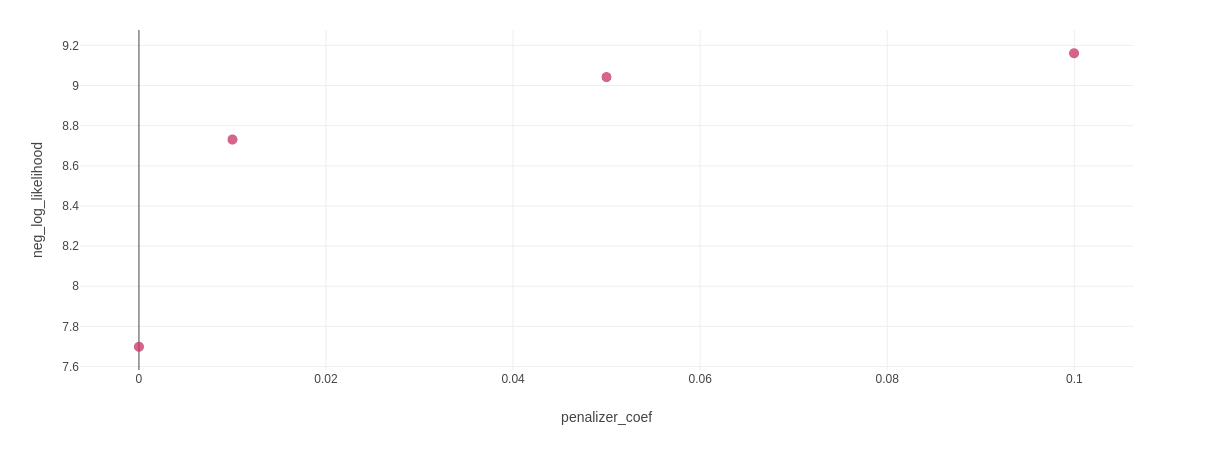
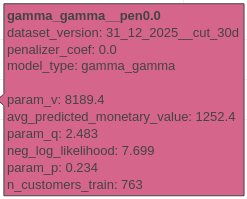

## Choose production model

In [95]:
promote_to_production("4973afd5021a4ddcaeebdae44c07540a")

In [102]:
ggf, ggf_metadata = load_gamma_gamma_model()

In [104]:
survival_model, survival_model_metadata = load_survival_analysis_model()

In [103]:
bgf, bgf_metadata = load_prod_bg_nbd()

## Inference

The requirements specified that the users can choose the model at inference. Instead of reloading the model each time, I have used a simple method cache the models, so we don't have to redownload the model each time.

In [122]:
MODEL_STORE = {}

In [123]:
estimate_clv(
    customer_id="C00013",
    method="bgnbd",
    horizon_days=30,
    BASE_GOLD_DIR=BASE_GOLD_DIR
)

{'customer_id': 'C00013',
 'method': 'bgnbd',
 'clv': 38629.8,
 'horizon_days': 30}

In [125]:
estimate_clv(
    customer_id="C00012",
    method="bgnbd",
    horizon_days=30,
    BASE_GOLD_DIR=BASE_GOLD_DIR
)

{'customer_id': 'C00012',
 'method': 'bgnbd',
 'clv': 64861.97,
 'horizon_days': 30}